In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.special import factorial
from scipy.optimize import fsolve


In [2]:
from IPython.display import display, Latex
%matplotlib notebook
plt.style.use('seaborn-notebook')

In [3]:
def get_D_Coeffs(s,d=2):
    '''
    Solve arbitrary stencil points s of length N with order of derivatives d<N
    can be obtained from equation on MIT website
    http://web.media.mit.edu/~crtaylor/calculator.html
    where the accuracy is determined as the usual form O(h^(N-d))
    
    Inputs:
        s: array like input of stencil points e.g. np.array([-3,-2,-1,0,1])
        d: order of desired derivative
    '''
    # let's solve an Ax=b problem
    N=s.size # stencil length
    A=[]
    for i in range(N):
        A.append(s**i)
    b=np.zeros(N)
    b[d] = factorial(d)
    x = np.linalg.solve(np.matrix(A),b)
    return x
def set_D(y,order=2,d=2,reduce_wall_order=True,output_full=False,periodic=False,uniform=True):
    '''
    Input:
        y: array of y values of channel
        order: order of accuracy desired (assuming even e.g. 2,4,6,...)
        d: dth derivative
    Output:
        D: (n-2 by n) dth derivative of order O(h^order) assuming uniform y spacing
    '''
    h = y[1]-y[0] # uniform spacing
    if not uniform:
        xi=np.linspace(0,1,y.size)
        h=xi[1] - xi[0]
    n = y.size
    ones=np.ones(n)
    I = np.eye(n)
    # get coefficients for main diagonals
    N=order+d # how many pts needed for order of accuracy
    if N>n:
        raise ValueError('You need more points in your domain, you need %i pts and you only gave %i'%(N,n))
    Nm1=N-1 # how many pts needed if using central difference is equal to N-1
    if (d % 2 != 0): # if odd derivative
        Nm1+=1 # add one more point to central, to count the i=0 0 coefficient
    # stencil and get Coeffs for diagonals
    s = np.arange(Nm1)-int((Nm1-1)/2) # stencil for central diff of order
    smax=s[-1] # right most stencil used (positive range)
    Coeffs = get_D_Coeffs(s,d=d)
    # loop over s and add coefficient matrices to D
    D = np.zeros_like(I)
    si = np.nditer(s,('c_index',))
    while not si.finished:
        i = si.index
        if si[0]==0:
            diag_to_add = np.diag(Coeffs[i] * ones,k=si[0])
        else:
            diag_to_add = np.diag(Coeffs[i] * ones[:-abs(si[0])],k=si[0])

        D += diag_to_add
        if periodic:
            if si[0]>0:
                diag_to_add = np.diag(Coeffs[i]*ones[:abs(si[0])],k=si[0]-n)
            elif si[0]<0:
                diag_to_add = np.diag(Coeffs[i]*ones[:abs(si[0])],k=si[0]+n)
            if si[0]!=0:
                D += diag_to_add
                
        si.iternext()
    if not periodic:
        # alter BC so we don't go out of range on bottom of channel
        for i in range(0,smax):
            # for ith row, set proper stencil coefficients
            if reduce_wall_order:
                if (d%2!=0): # if odd derivative
                    s = np.arange(Nm1-1)-i # stencil for shifted diff of order-1
                else:
                    s = np.arange(Nm1)-i # stencil for shifted diff of order-1
            else:
                s = np.arange(N)-i # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D[i,:] = 0. # set row to zero
            D[i,s+i] = Coeffs # set row to have proper coefficients

            # for -ith-1 row, set proper stencil coefficients
            if reduce_wall_order:
                if (d%2!=0): # if odd derivative
                    s = -(np.arange(Nm1-1)-i) # stencil for shifted diff of order-1
                else:
                    s = -(np.arange(Nm1)-i) # stencil for shifted diff of order-1
            else:
                s = -(np.arange(N)-i) # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D[-i-1,:] = 0. # set row to zero
            D[-i-1,s-i-1] = Coeffs # set row to have proper coefficients

    if output_full:
        D = (1./(h**d)) * D # do return the full matrix
    else:
        D = (1./(h**d)) * D[1:-1,:] # do not return the top or bottom row
    if not uniform:
        D = map_D(D,y,order=order,d=d,reduce_wall_order=reduce_wall_order,output_full=output_full,periodic=periodic,uniform=uniform)
    return D 
def map_D(D,y,order=2,d=2,reduce_wall_order=True,output_full=False,periodic=False,uniform=True):
    if not uniform:
        xi=np.linspace(0,1,y.size)
        if d==1: # if 1st derivative operator d(.)/dy = d(.)/dxi * dxi/dy
            dydxi = D@y # matrix multiply in python3
            dxidy = 1./dydxi # element wise invert
            return D*dxidy[:,np.newaxis] # d(.)/dy = d(.)/dxi * dxi/dy
        elif d==2: # d^2()/dy^2 = d^2()/dxi^2 (dxi/dy)^2 + d()/dxi d^2xi/dy^2
            D1=set_D(xi,order=order,d=1,reduce_wall_order=reduce_wall_order,output_full=output_full,periodic=periodic,uniform=True)
            dydxi = D1@y
            dxidy = 1./dydxi # element wise invert
            #d2ydxi2 = D@y # d^2y/dxi^2
            #d2xidy2 = 1./d2ydxi2 # d^2xi/dy^2 = 1./(d^2y/dxi^2)
            d2xidy2 = -(D@y)*(dxidy)**3
            #print('d2xidy2 = ',d2xidy2)
            return (D*(dxidy[:,np.newaxis]**2)) + (D1*d2xidy2[:,np.newaxis])  # d^2()/dy^2 = d^2()/dxi^2 (dxi/dy)^2 + d()/dxi d^2xi/dy^2
        else:
            print('Cannot do this order of derivative with non-uniform mesh.  your input order of derivative = ',d)
    else:
        return D

# mesh and upload txt file for query [JHTDB ](http://turbulence.pha.jhu.edu/webquery/query.aspx)


In [131]:
x = np.arange(30.21850,1000.065,0.292210466)
y = np.genfromtxt('y.txt')
y = np.insert(y,0,0.0)
z = np.arange(0.0,26.48795,0.117244748)

In [132]:
X,Y,Z = np.meshgrid(x,y,z,indexing='ij')

In [55]:
# slice near first of plate 
xf,xl=0,5 # first 5 points
yf,yl=0,len(y) # all points
zf,zl=10,20 # middle points
Xf,Yf,Zf = X[xf:xl,yf:yl,zf:zl],Y[xf:xl,yf:yl,zf:zl],Z[xf:xl,yf:yl,zf:zl]

In [56]:
n = len(Xf.flatten())
text_csv=np.zeros((n,3))
text_csv[:,0]=Xf.flatten()
text_csv[:,1]=Yf.flatten()
text_csv[:,2]=Zf.flatten()

In [57]:
np.savetxt('file_to_upload_to_JHTDB.csv',text_csv,delimiter=',')

# read in time averaged state
Notes for Transition_BL_Time_Averaged_Profiles.h5

This is the time averaged profile of the transitional boundary layer dataset.

The time interval used to caculate the profiles is 0.5 and the statistics covers a time span of 1175.

x_coor, y_coor and z_coor are the coordinates of the grid points where the data are stored in the dataset.

um, vm, wm and pm are time-averaged of $u$ ($x$ direction), $v$ ($y$ direction), $w$ ($z$ direction) and $p$, respectively.

uum is the time-averaged of $uu$ (not $u'u'$, where $u'=u-\overline{u}$). So time-averaged of $\overline{u'u'}=\overline{uu} - \bar{u} \bar{u}$=uum-um*um. Same for other quantities.

### Readme paper
$Re_L = \frac{U_\infty L}{\nu}=800$ and stored data corresponds to $x \in [30.2185,1000.065]L$, $y\in [0.0036, 26.4880]L$, and $z \in [0, 240]L$

Similar to T3A input with Tu=3%

$U_\infty=1$ reference velocity scale

$L=1$ half thickness of plate, reference length scale

$\nu=1.25E-3$ viscosity

In [4]:
Re=800
Uinf=1
L=1
nu=1.25E-3

In [6]:
Base=h5py.File('Transition_BL_Time_Averaged_Profiles.h5')

In [7]:
for k in Base.keys():
    print(Base[k])

<HDF5 dataset "pm": shape (224, 3320), type "<f8">
<HDF5 dataset "ppm": shape (224, 3320), type "<f8">
<HDF5 dataset "um": shape (224, 3320), type "<f8">
<HDF5 dataset "upm": shape (224, 3320), type "<f8">
<HDF5 dataset "uum": shape (224, 3320), type "<f8">
<HDF5 dataset "uvm": shape (224, 3320), type "<f8">
<HDF5 dataset "uwm": shape (224, 3320), type "<f8">
<HDF5 dataset "vm": shape (224, 3320), type "<f8">
<HDF5 dataset "vpm": shape (224, 3320), type "<f8">
<HDF5 dataset "vvm": shape (224, 3320), type "<f8">
<HDF5 dataset "vwm": shape (224, 3320), type "<f8">
<HDF5 dataset "wm": shape (224, 3320), type "<f8">
<HDF5 dataset "wpm": shape (224, 3320), type "<f8">
<HDF5 dataset "wwm": shape (224, 3320), type "<f8">
<HDF5 dataset "x_coor": shape (3320,), type "<f8">
<HDF5 dataset "y_coor": shape (224,), type "<f8">
<HDF5 dataset "z_coor": shape (2048,), type "<f8">


In [8]:
print(Base['x_coor'])
print(Base['y_coor'])
print(Base['z_coor'])
print(Base['um'])
print(Base['vm'])
print(Base['wm'])

<HDF5 dataset "x_coor": shape (3320,), type "<f8">
<HDF5 dataset "y_coor": shape (224,), type "<f8">
<HDF5 dataset "z_coor": shape (2048,), type "<f8">
<HDF5 dataset "um": shape (224, 3320), type "<f8">
<HDF5 dataset "vm": shape (224, 3320), type "<f8">
<HDF5 dataset "wm": shape (224, 3320), type "<f8">


In [9]:
u=Base['um'][:]
uu=Base['uum'][:]
v=Base['vm'][:]
vv=Base['vvm'][:]
w=Base['wm'][:]
ww=Base['wwm'][:]
p=Base['pm'][:]
pp=Base['ppm'][:]
uv=Base['uvm'][:]
uw=Base['uwm'][:]
vw=Base['vwm'][:]
x=Base['x_coor'][:]
y=Base['y_coor'][:]
z=Base['z_coor'][:]

In [10]:
ny,nx = u.shape

In [11]:
X,Y=np.meshgrid(x,y)

<IPython.core.display.Javascript object>


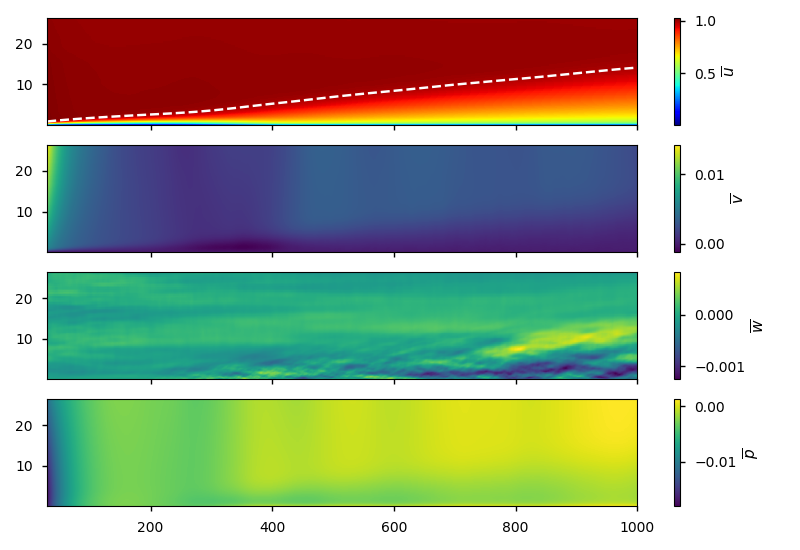

In [12]:
fig,axs=plt.subplots(nrows=4,sharey=True,sharex=True)
axU,axV,axW,axP=axs
fig.colorbar(axU.pcolormesh(x,y,u,cmap=plt.cm.jet),ax=axU,label=r'$\overline{u}$')
axU.contour(x,y,u,levels=[0.99,],colors='w',linestyles='--')
fig.colorbar(axV.pcolormesh(x,y,v),ax=axV,label=r'$\overline{v}$')
fig.colorbar(axW.pcolormesh(x,y,w),ax=axW,label=r'$\overline{w}$')
fig.colorbar(axP.pcolormesh(x,y,p),ax=axP,label=r'$\overline{p}$')
#[ax.set_aspect('equal') for ax in axs]
fig.tight_layout()

<IPython.core.display.Javascript object>


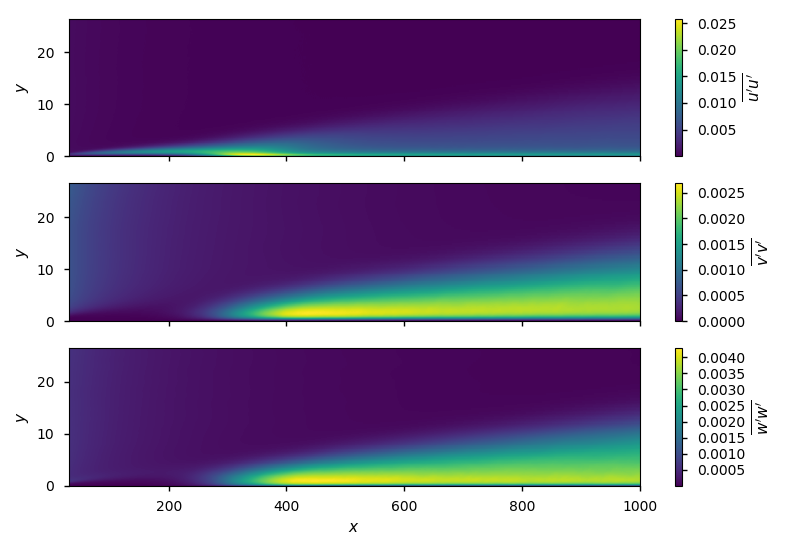

In [15]:
fig,axs=plt.subplots(nrows=3,sharey=True,sharex=True)
axU,axV,axW=axs
fig.colorbar(axU.pcolormesh(x,y,uu-u*u,),ax=axU,label=r"$\overline{u'u'}$")
fig.colorbar(axV.pcolormesh(x,y,vv-v*v,),ax=axV,label=r"$\overline{v'v'}$")
fig.colorbar(axW.pcolormesh(x,y,ww-w*w,),ax=axW,label=r"$\overline{w'w'}$")
axW.set_xlabel(r'$x$')
[ax.set_ylabel(r'$y$') for ax in axs]
fig.tight_layout()

<IPython.core.display.Javascript object>


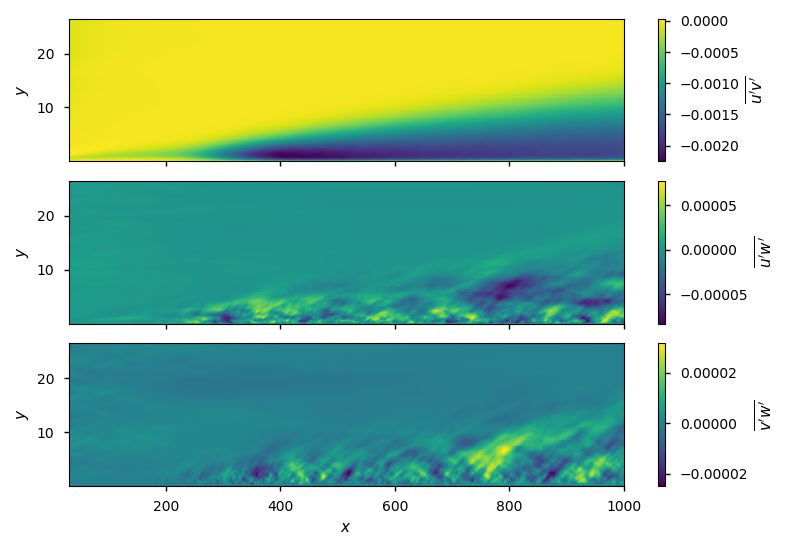

In [13]:
fig,axs=plt.subplots(nrows=3,sharey=True,sharex=True)
axU,axV,axW=axs
fig.colorbar(axU.pcolormesh(x,y,uv-u*v,),ax=axU,label=r"$\overline{u'v'}$")
fig.colorbar(axV.pcolormesh(x,y,uw-u*w,),ax=axV,label=r"$\overline{u'w'}$")
fig.colorbar(axW.pcolormesh(x,y,vw-v*w,),ax=axW,label=r"$\overline{v'w'}$")
axW.set_xlabel(r'$x$')
[ax.set_ylabel(r'$y$') for ax in axs]
fig.tight_layout()

<IPython.core.display.Javascript object>


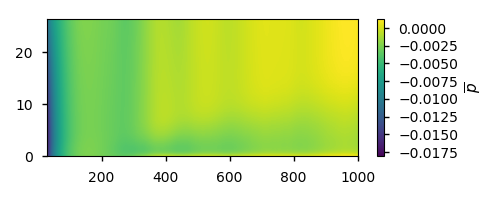

<IPython.core.display.Javascript object>


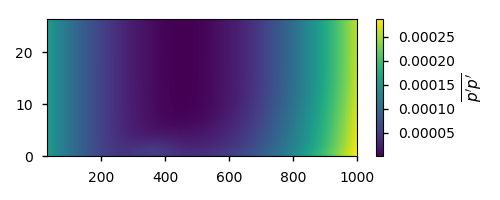

In [18]:
fig,ax=plt.subplots(figsize=(5,2))
fig.colorbar(ax.pcolormesh(x,y,p),label=r"$\overline{p}$")
fig.tight_layout()
fig,ax=plt.subplots(figsize=(5,2))
fig.colorbar(ax.pcolormesh(x,y,pp-p*p),label=r"$\overline{p'p'}$")
fig.tight_layout()

<IPython.core.display.Javascript object>


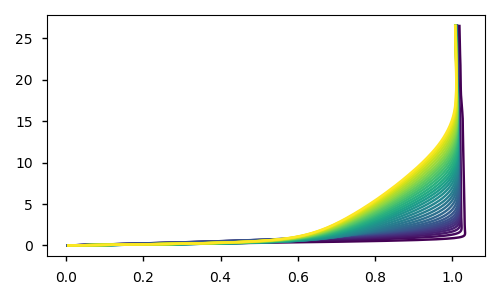

In [14]:
fig,ax=plt.subplots(figsize=(5,3))
skip_lines=100
ax.set_prop_cycle(color=[plt.cm.viridis(i) for i in np.linspace(0,1,len(u[0,::skip_lines]))])
ax.plot(u[:,::skip_lines],Base['y_coor'])
fig.tight_layout()

In [13]:
# derivative operators on data set
Dx = set_D(x,d=1,output_full=True,uniform=False)
Dy = set_D(y,d=1,output_full=True,uniform=False)
Dxx = set_D(x,d=2,output_full=True,uniform=False)
Dyy = set_D(y,d=2,output_full=True,uniform=False)
def ddx(var):
    '''Take derivative with respect to x
    Inputs:
      var - variable to take derivative of
    Returns:
      d(var)/dx
      
    Be sure that x and Dx are global variables defined already and that var is of shape (nx,ny)
    
    '''
    dvar_dx = Dx@var
    return dvar_dx
def ddy(var):
    '''Take derivative with respect to y
    Inputs:
      var - variable to take derivative of
    Returns:
      d(var)/dy
      
    Be sure that y and Dy are global variables defined already and that var is of shape (nx,ny)
    
    '''
    dvar_dy = Dy@(var.T)
    return dvar_dy.T
def d2dx2(var):
    '''Take second derivative with respect to x
    Inputs:
      var - variable to take derivative of
    Returns:
      d^2(var)/dx^2
      
    Be sure that x and Dxx are global variables defined already and that var is of shape (nx,ny)
    
    '''
    d2var_dx2 = Dxx@var
    return d2var_dx2
def d2dy2(var):
    '''Take second derivative with respect to y
    Inputs:
      var - variable to take derivative of
    Returns:
      d^2(var)/dy^2
      
    Be sure that y and Dyy are global variables defined already and that var is of shape (nx,ny)
    
    '''
    d2var_dy2 = Dyy@(var.T)
    return d2var_dy2.T

<IPython.core.display.Javascript object>


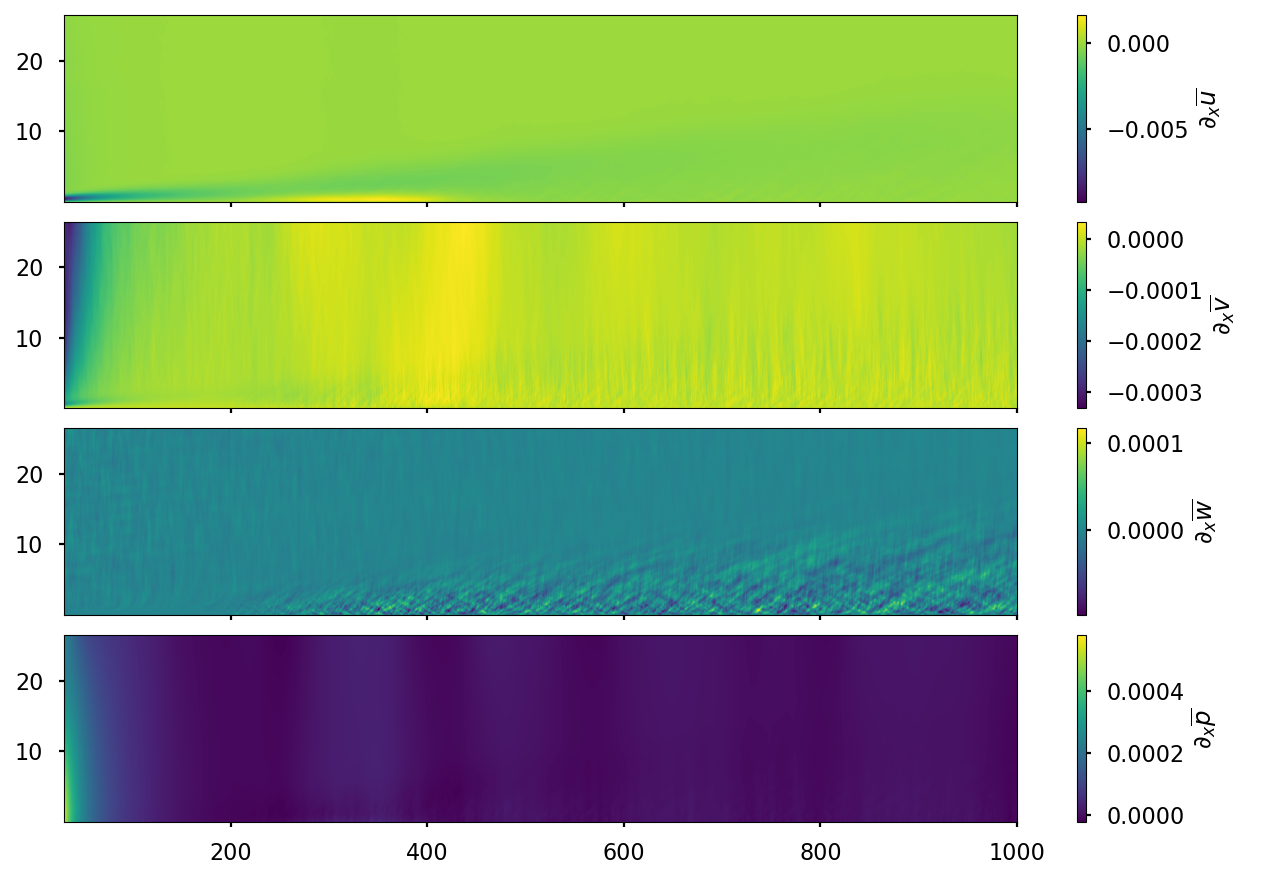

In [34]:
fig,axs=plt.subplots(nrows=4,sharey=True,sharex=True)
axU,axV,axW,axP=axs
fig.colorbar(axU.pcolormesh(x,y,ddx(u.T).T),ax=axU,label=r'$\partial_x\overline{u}$')
fig.colorbar(axV.pcolormesh(x,y,ddx(v.T).T),ax=axV,label=r'$\partial_x\overline{v}$')
fig.colorbar(axW.pcolormesh(x,y,ddx(w.T).T),ax=axW,label=r'$\partial_x\overline{w}$')
fig.colorbar(axP.pcolormesh(x,y,ddx(p.T).T),ax=axP,label=r'$\partial_x\overline{p}$')
#[ax.set_aspect('equal') for ax in axs]
fig.tight_layout()

<IPython.core.display.Javascript object>


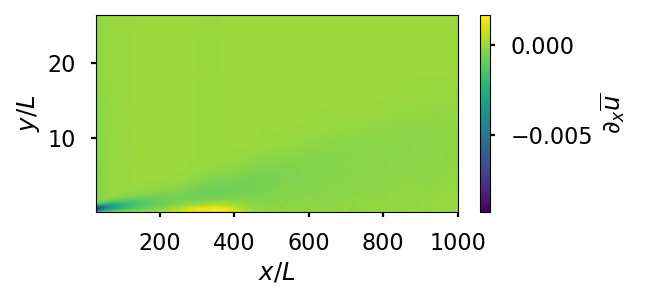

In [31]:
fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,ddx(u.T).T),ax=ax,label=r'$\partial_x\overline{u}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('dubardx_poster.png',dpi=600)


<IPython.core.display.Javascript object>


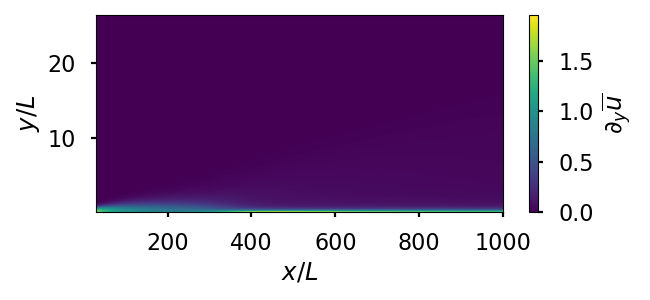

In [30]:
fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,ddy(u.T).T),ax=ax,label=r'$\partial_y\overline{u}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('dubardy_poster.png',dpi=600)


In [29]:
plt.style.use('seaborn-poster')

<IPython.core.display.Javascript object>


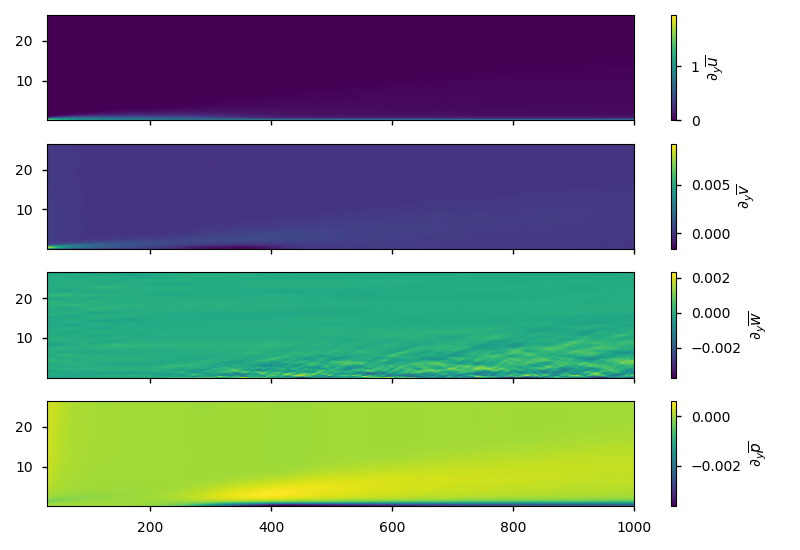

In [18]:
fig,axs=plt.subplots(nrows=4,sharey=True,sharex=True)
axU,axV,axW,axP=axs
fig.colorbar(axU.pcolormesh(x,y,ddy(u.T).T),ax=axU,label=r'$\partial_y\overline{u}$')
fig.colorbar(axV.pcolormesh(x,y,ddy(v.T).T),ax=axV,label=r'$\partial_y\overline{v}$')
fig.colorbar(axW.pcolormesh(x,y,ddy(w.T).T),ax=axW,label=r'$\partial_y\overline{w}$')
fig.colorbar(axP.pcolormesh(x,y,ddy(p.T).T),ax=axP,label=r'$\partial_y\overline{p}$')
#[ax.set_aspect('equal') for ax in axs]
fig.tight_layout()

<IPython.core.display.Javascript object>


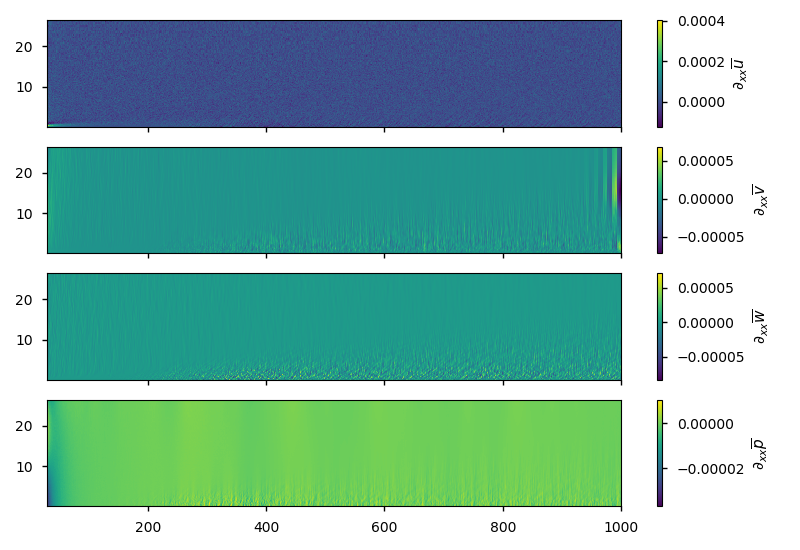

In [19]:
fig,axs=plt.subplots(nrows=4,sharey=True,sharex=True)
axU,axV,axW,axP=axs
fig.colorbar(axU.pcolormesh(x,y,d2dx2(u.T).T),ax=axU,label=r'$\partial_{xx}\overline{u}$')
fig.colorbar(axV.pcolormesh(x,y,d2dx2(v.T).T),ax=axV,label=r'$\partial_{xx}\overline{v}$')
fig.colorbar(axW.pcolormesh(x,y,d2dx2(w.T).T),ax=axW,label=r'$\partial_{xx}\overline{w}$')
fig.colorbar(axP.pcolormesh(x,y,d2dx2(p.T).T),ax=axP,label=r'$\partial_{xx}\overline{p}$')
#[ax.set_aspect('equal') for ax in axs]
fig.tight_layout()

<IPython.core.display.Javascript object>


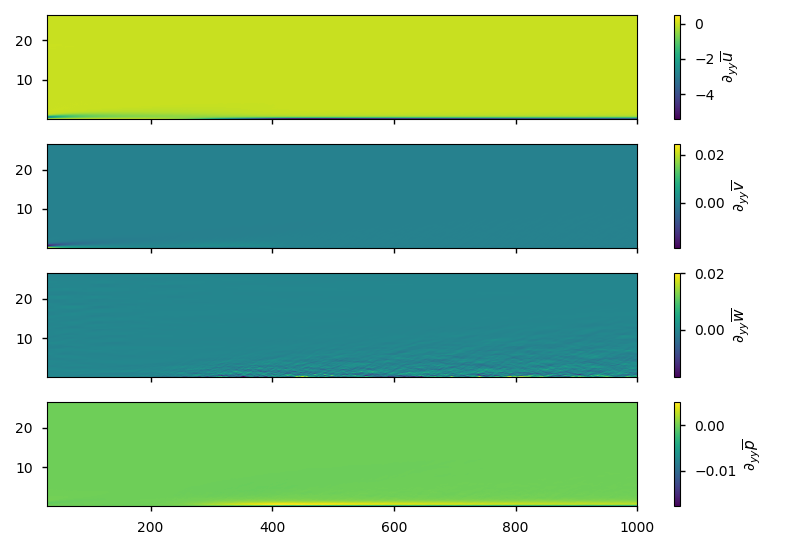

In [20]:
fig,axs=plt.subplots(nrows=4,sharey=True,sharex=True)
axU,axV,axW,axP=axs
fig.colorbar(axU.pcolormesh(x,y,d2dy2(u.T).T),ax=axU,label=r'$\partial_{yy}\overline{u}$')
fig.colorbar(axV.pcolormesh(x,y,d2dy2(v.T).T),ax=axV,label=r'$\partial_{yy}\overline{v}$')
fig.colorbar(axW.pcolormesh(x,y,d2dy2(w.T).T),ax=axW,label=r'$\partial_{yy}\overline{w}$')
fig.colorbar(axP.pcolormesh(x,y,d2dy2(p.T).T),ax=axP,label=r'$\partial_{yy}\overline{p}$')
#[ax.set_aspect('equal') for ax in axs]
fig.tight_layout()

<IPython.core.display.Javascript object>


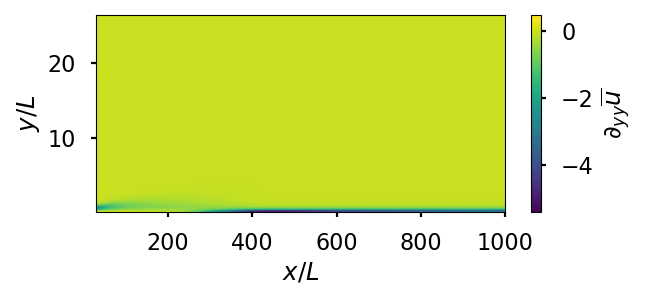

In [32]:
fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,d2dy2(u.T).T),ax=ax,label=r'$\partial_{yy}\overline{u}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('d2ubardy2_poster.png',dpi=600)


<IPython.core.display.Javascript object>


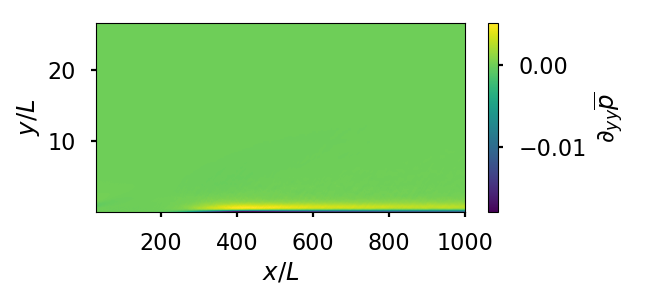

In [33]:
fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,d2dy2(p.T).T),ax=ax,label=r'$\partial_{yy}\overline{p}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('d2pbardy2_poster.png',dpi=600)


<IPython.core.display.Javascript object>


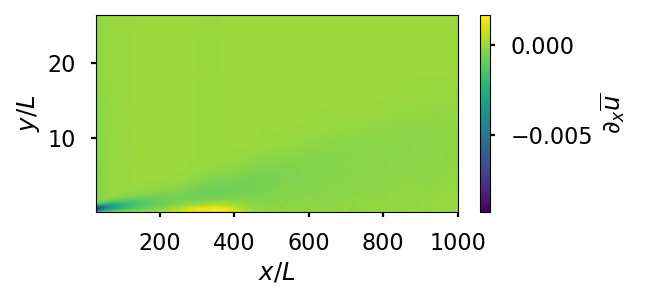

<IPython.core.display.Javascript object>


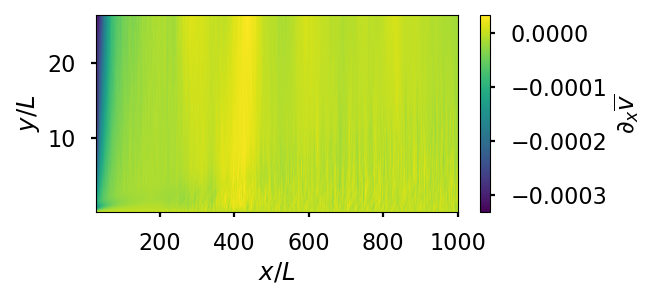

<IPython.core.display.Javascript object>


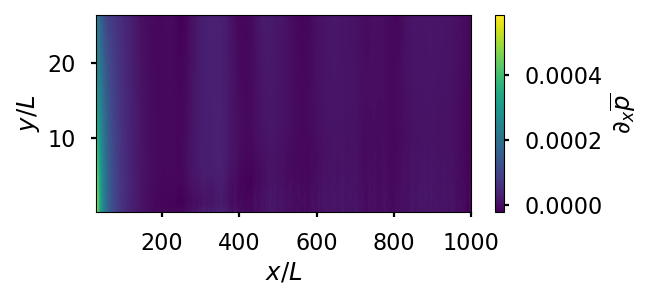

<IPython.core.display.Javascript object>


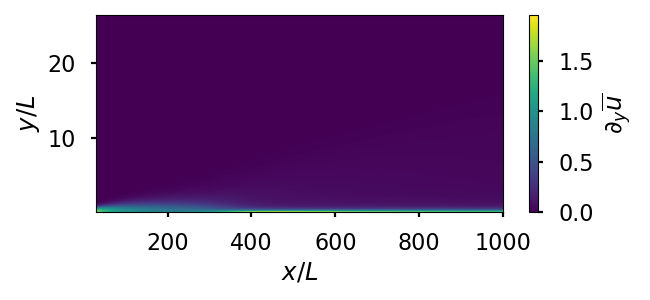

<IPython.core.display.Javascript object>


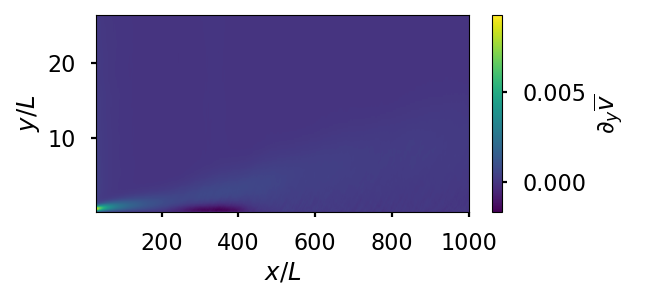

<IPython.core.display.Javascript object>


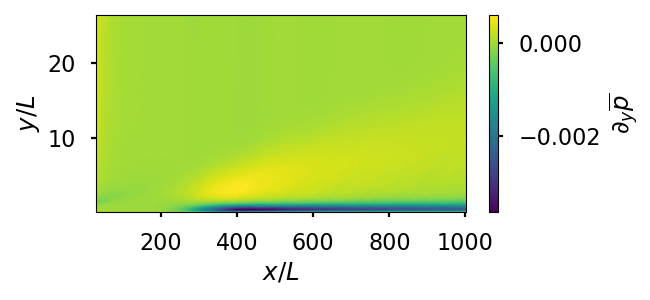

<IPython.core.display.Javascript object>


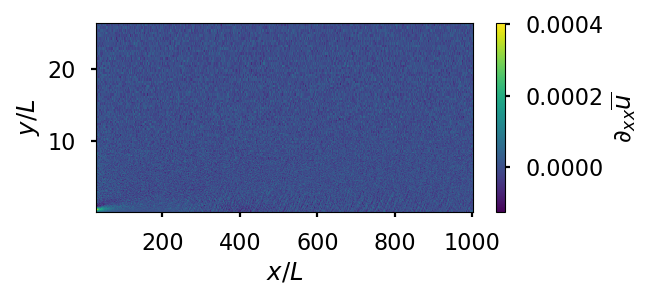

<IPython.core.display.Javascript object>


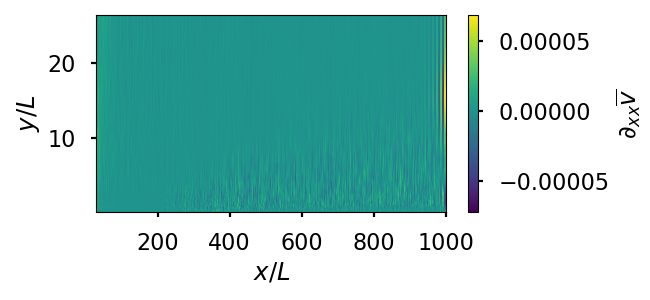

<IPython.core.display.Javascript object>


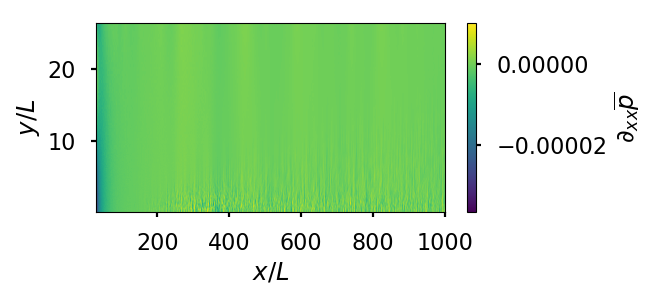

<IPython.core.display.Javascript object>


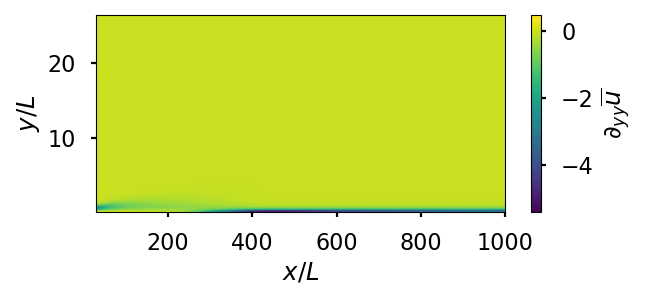

<IPython.core.display.Javascript object>


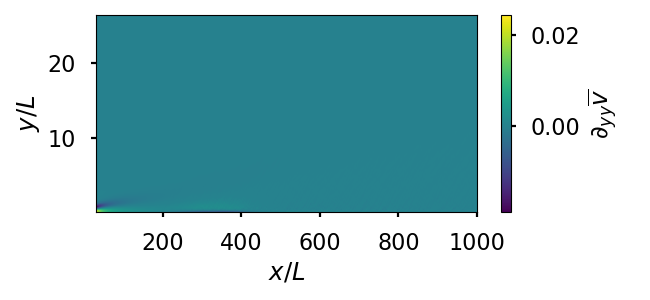

<IPython.core.display.Javascript object>


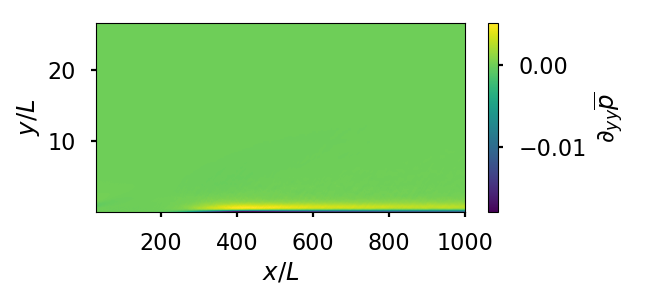

<IPython.core.display.Javascript object>


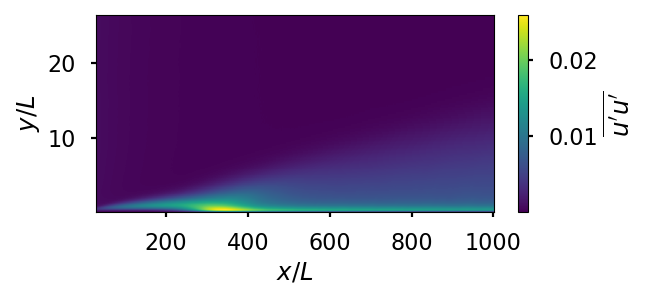

<IPython.core.display.Javascript object>


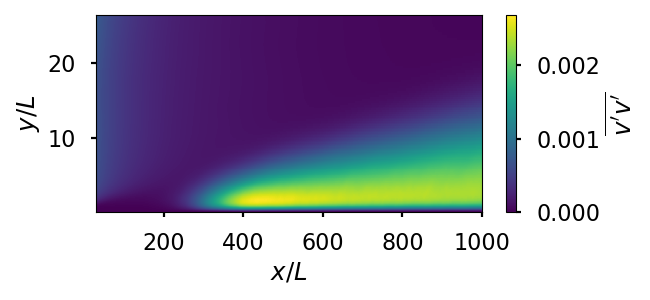

/home/srharris/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


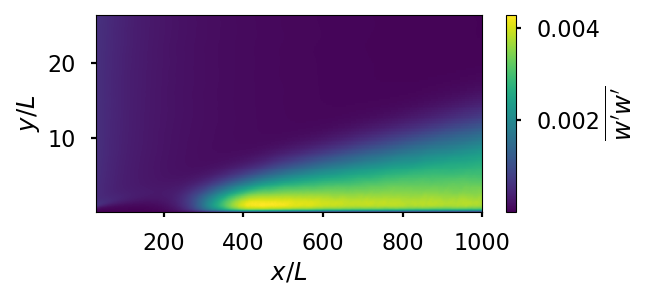

/home/srharris/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


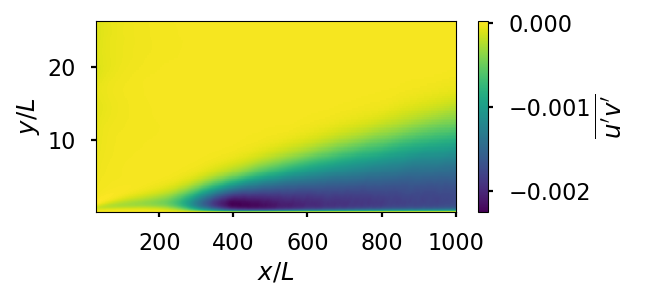

In [44]:
# ddx u,v,P
fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,ddx(u.T).T),ax=ax,label=r'$\partial_{x}\overline{u}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('dubardx_poster.png',dpi=600)

fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,ddx(v.T).T),ax=ax,label=r'$\partial_{x}\overline{v}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('dvbardx_poster.png',dpi=600)

fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,ddx(p.T).T),ax=ax,label=r'$\partial_{x}\overline{p}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('dpbardx_poster.png',dpi=600)

# ddy u,v,P
fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,ddy(u.T).T),ax=ax,label=r'$\partial_{y}\overline{u}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('dubardy_poster.png',dpi=600)

fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,ddy(v.T).T),ax=ax,label=r'$\partial_{y}\overline{v}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('dvbardy_poster.png',dpi=600)

fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,ddy(p.T).T),ax=ax,label=r'$\partial_{y}\overline{p}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('dpbardy_poster.png',dpi=600)

# d2dx2 u,v,P
fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,d2dx2(u.T).T),ax=ax,label=r'$\partial_{xx}\overline{u}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('d2ubardx2_poster.png',dpi=600)

fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,d2dx2(v.T).T),ax=ax,label=r'$\partial_{xx}\overline{v}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('d2vbardx2_poster.png',dpi=600)

fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,d2dx2(p.T).T),ax=ax,label=r'$\partial_{xx}\overline{p}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('d2pbardx2_poster.png',dpi=600)

# d2dx2 u,v,P
fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,d2dy2(u.T).T),ax=ax,label=r'$\partial_{yy}\overline{u}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('d2ubardy2_poster.png',dpi=600)

fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,d2dy2(v.T).T),ax=ax,label=r'$\partial_{yy}\overline{v}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('d2vbardy2_poster.png',dpi=600)

fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,d2dy2(p.T).T),ax=ax,label=r'$\partial_{yy}\overline{p}$')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('d2pbardy2_poster.png',dpi=600)

# u'u',v'v',w'w', u'v'
fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,uu-u*u),ax=ax,label=r"$\overline{u'u'}$")
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('upupbar_poster.png',dpi=600)

fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,vv-v*v),ax=ax,label=r"$\overline{v'v'}$")
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('vpvpbar_poster.png',dpi=600)

fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,ww-w*w),ax=ax,label=r"$\overline{w'w'}$")
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('wpwpbar_poster.png',dpi=600)

fig,ax=plt.subplots(figsize=(6.5,3))
fig.colorbar(ax.pcolormesh(x,y,uv-u*v),ax=ax,label=r"$\overline{u'v'}$")
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
fig.tight_layout()
fig.savefig('upvpbar_poster.png',dpi=600)

## Export desired quantities
export as inputs $\overline{u}$, 
$\overline{v}$, 
$\overline{P}$, 
$\overline{\partial_x u}$, 
$\overline{\partial_x v}$, 
$\overline{\partial_x P}$, 
$\overline{\partial_y u}$, 
$\overline{\partial_y v}$, 
$\overline{\partial_y P}$, 
$\overline{\partial_{xx} u}$, 
$\overline{\partial_{xx} v}$, 
$\overline{\partial_{xx} P}$, 
$\overline{\partial_{yy} u}$, 
$\overline{\partial_{yy} v}$, 
$\overline{\partial_{yy} P}$, and
$\nu$

and export as outputs
$\overline{u'u'}$, 
$\overline{v'v'}$, 
$\overline{w'w'}$, 
$\overline{u'v'}$, 
$\overline{u'w'}$, and
$\overline{v'w'}$


In [21]:
print(X.shape)
print(u.size)

(224, 3320)
743680


In [16]:
u.shape

(224, 3320)

In [22]:
224*3320

743680

In [35]:
n=u[:,10:-10].size
nin=14
nout=6
data = np.zeros((n,nin+nout))
# inputs
#data[:,0]=u.flatten()
#data[:,1]=v.flatten()
data[:,0]=p[:,10:-10] .flatten()
data[:,1]=ddx(u.T).T[:,10:-10].flatten()
data[:,2]=ddx(v.T).T[:,10:-10].flatten()
data[:,3]=ddx(p.T).T[:,10:-10].flatten()
data[:,4]=ddy(u.T).T[:,10:-10].flatten()
data[:,5]=ddy(v.T).T[:,10:-10].flatten()
data[:,6]=ddy(p.T).T[:,10:-10].flatten()
data[:,7]=d2dx2(u.T).T[:,10:-10].flatten()
data[:,8]=d2dx2(v.T).T[:,10:-10].flatten()
data[:,9]=d2dx2(p.T).T[:,10:-10].flatten()
data[:,10]=d2dy2(u.T).T[:,10:-10].flatten()
data[:,11]=d2dy2(v.T).T[:,10:-10].flatten()
data[:,12]=d2dy2(p.T).T[:,10:-10].flatten()
data[:,13]=nu
#data[:,16]=X.flatten()
#data[:,17]=Y.flatten()
# outputs
data[:,14]=(uu-u*u)[:,10:-10].flatten()
data[:,15]=(vv-v*v)[:,10:-10].flatten()
data[:,16]=(ww-w*w)[:,10:-10].flatten()
data[:,17]=(uv-u*v)[:,10:-10].flatten()
data[:,18]=(uw-u*w)[:,10:-10].flatten()
data[:,19]=(vw-v*w)[:,10:-10].flatten()

#np.savetxt('Shaun_JHTDB_data.csv',data,delimiter=',',header='u,v,p,dudx,dvdx,dpdx,dudy,dvdy,dpdy,d2udx2,d2vdx2,d2pdx2,d2udy2,d2vdy2,d2pdy2,nu,uu,vv,ww,uv,uw,vw')
np.savetxt('Shaun_JHTDB_data.csv',data,delimiter=',',header='p,dudx,dvdx,dpdx,dudy,dvdy,dpdy,d2udx2,d2vdx2,d2pdx2,d2udy2,d2vdy2,d2pdy2,nu,uu,vv,ww,uv,uw,vw')

In [61]:
# how to read in data
#data2=np.genfromtxt('Shaun_JHTDB_data.csv',delimiter=',',names=True)
#data=np.genfromtxt('Shaun_JHTDB_data.csv',delimiter=',')

In [21]:
Base.close()